# Outlier detection in healthcare data

A study of various analytic methods which can be used to identify unusual, possibly fraudulent healthcare claims.

1. [Importing and examining data](#import)
2. [Two variables, regression based approaches](#reg)
3. [ > 2 variables, CBLOF Approach](#cblof)
4. [> 2 variables, K Nearest Neighbors Approach](#knn)
5. [Results](#results)

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import rcParams
from sklearn.decomposition import PCA

sns.set_context("talk", font_scale = 1)
style.use('seaborn-whitegrid')

## Importing and examining data

In [2]:
data = pd.read_csv('healthcare_providers.csv', index_col=0)

In [3]:
data.head()

,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,City of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
index,,,,,,,,,,,,,,,,,,,,,
8774979,1891106191,UPADHYAYULA,SATYASREE,NaN,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,SAINT LOUIS,...,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,NaN,FAYETTEVILLE,...,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,NORTH HAVEN,...,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
7594822,1770523540,FULLARD,JASPER,NaN,MD,M,I,5746 N BROADWAY ST,NaN,KANSAS CITY,...,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,JUPITER,...,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758


In [4]:
data.columns

Index(['National Provider Identifier',
       'Last Name/Organization Name of the Provider',
       'First Name of the Provider', 'Middle Initial of the Provider',
       'Credentials of the Provider', 'Gender of the Provider',
       'Entity Type of the Provider', 'Street Address 1 of the Provider',
       'Street Address 2 of the Provider', 'City of the Provider',
       'Zip Code of the Provider', 'State Code of the Provider',
       'Country Code of the Provider', 'Provider Type',
       'Medicare Participation Indicator', 'Place of Service', 'HCPCS Code',
       'HCPCS Description', 'HCPCS Drug Indicator', 'Number of Services',
       'Number of Medicare Beneficiaries',
       'Number of Distinct Medicare Beneficiary/Per Day Services',
       'Average Medicare Allowed Amount', 'Average Submitted Charge Amount',
       'Average Medicare Payment Amount',
       'Average Medicare Standardized Amount'],
      dtype='object')

In [5]:
data['Entity Type of the Provider'].value_counts()

I    95746
O     4254
Name: Entity Type of the Provider, dtype: int64

I: Individual
O: Organization

In [6]:
data['HCPCS Drug Indicator'].value_counts()

N    93802
Y     6198
Name: HCPCS Drug Indicator, dtype: int64

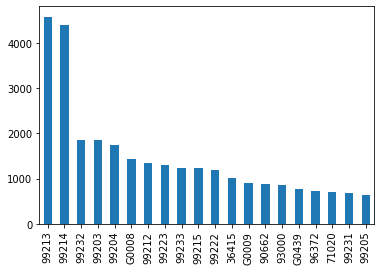

In [7]:
data['HCPCS Code'].value_counts()[:20].plot.bar()

In [8]:
data['Provider Type'].value_counts()

Diagnostic Radiology                                12537
Internal Medicine                                   11366
Family Practice                                      9760
Nurse Practitioner                                   5713
Cardiology                                           4602
                                                    ...  
Clinic or Group Practice                                7
Radiation Therapy Center                                3
Mammography Center                                      3
Advanced Heart Failure and Transplant Cardiology        1
Pharmacy                                                1
Name: Provider Type, Length: 90, dtype: int64

In [9]:
data['Medicare Participation Indicator'].value_counts()

Y    99969
N       31
Name: Medicare Participation Indicator, dtype: int64

In [10]:
data_us = data[data['Country Code of the Provider'] == 'US']
data_usmed = data_us[data_us['Medicare Participation Indicator'] == 'Y']

In [14]:
data_usmed.dtypes

National Provider Identifier                                  int64
Last Name/Organization Name of the Provider                  object
First Name of the Provider                                   object
Middle Initial of the Provider                               object
Credentials of the Provider                                  object
Gender of the Provider                                       object
Entity Type of the Provider                                  object
Street Address 1 of the Provider                             object
Street Address 2 of the Provider                             object
City of the Provider                                         object
Zip Code of the Provider                                    float64
State Code of the Provider                                   object
Country Code of the Provider                                 object
Provider Type                                                object
Medicare Participation Indicator                

The numeric column seem to be in string format, convert them to numeric:

In [15]:
num_cols = ['Number of Services',
            'Average Medicare Standardized Amount',   
            'Number of Medicare Beneficiaries',
            'Number of Distinct Medicare Beneficiary/Per Day Services',
            'Average Medicare Allowed Amount',
            'Average Submitted Charge Amount',
            'Average Medicare Payment Amount']

for col in num_cols:
    data_usmed[col] = data_usmed[col].apply(pd.to_numeric, errors='coerce')

<ipython-input-15-50dacf603663>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_usmed[col] = data_usmed[col].apply(pd.to_numeric, errors='coerce')


## Examining the distributions of the claims data

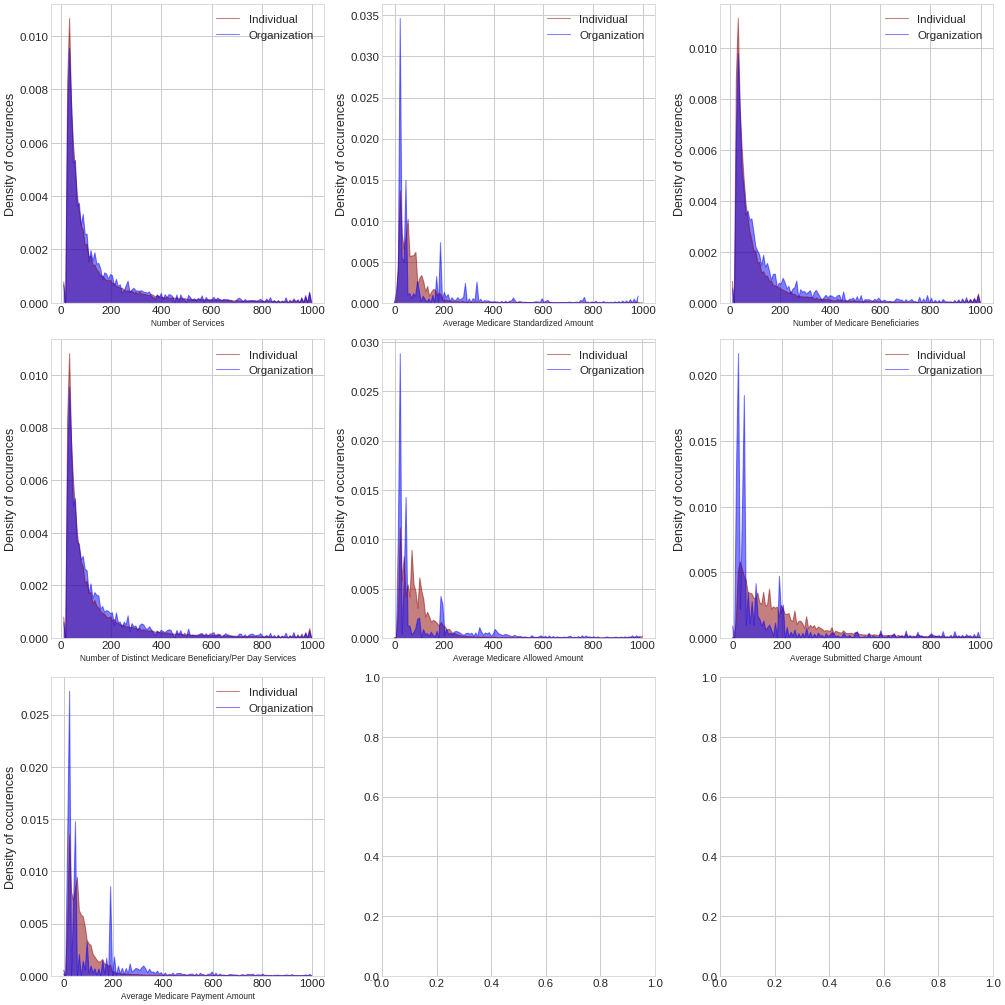

In [19]:
def density_plot(col, ax):
    sns.kdeplot(data_usmed[data_usmed['Entity Type of the Provider']=='I'][col], clip_on=False, shade=True, alpha=0.5, 
                lw=1.5, bw=0.2, color = 'darkred', ax=ax)
    sns.kdeplot(data_usmed[data_usmed['Entity Type of the Provider']=='O'][col], clip_on=False, shade=True, alpha=0.5, 
               lw=1.5, bw=0.2, color='blue', ax=ax)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Density of occurences')
    ax.legend(['Individual','Organization'])
    

fig, ax = plt.subplots(3,3,figsize=(20,20), dpi=50, constrained_layout=True)

for i, col in enumerate(data_usmed[num_cols]):
    density_plot(col, ax[i//3][i%3])

The payment amounts have long tails, perhaps some of the higher value claims are suspicious.

<a id='reg'></a>
## 2. Linear Regression Approaches

It is likely that some unusal claims can be identified by using linear regression on two variables of interest, and examining statistical outliers. First, need to drop null values from the numeric columns.

## A. Ordinary Least Squares regression using statsmodels

In [21]:
data_usmed.dropna(subset=num_cols, inplace=True)

<ipython-input-21-2c57678dc89b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_usmed.dropna(subset=num_cols, inplace=True)


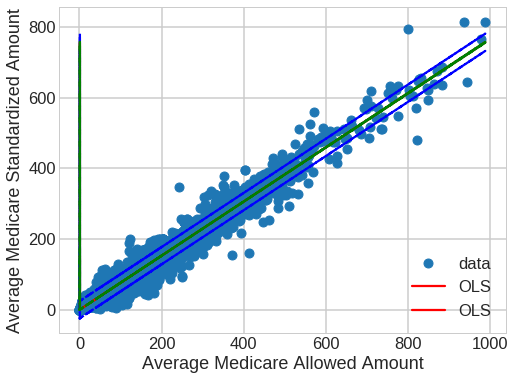

In [24]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

x = data_usmed['Average Medicare Allowed Amount'].values
y = data_usmed['Average Medicare Standardized Amount'].values
X = sm.add_constant(x)
res = sm.OLS(y, X).fit()

st, data, ss2 = summary_table(res, alpha=0.01)
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="data")
ax.plot(X, fittedvalues, 'r-', label='OLS')
ax.plot(X, predict_ci_low, 'b--')
ax.plot(X, predict_ci_upp, 'b--')
ax.plot(X, predict_mean_ci_low, 'g--')
ax.plot(X, predict_mean_ci_upp, 'g--')
ax.set_xlabel('Average Medicare Allowed Amount')
ax.set_ylabel('Average Medicare Standardized Amount')
ax.legend(loc='best');
plt.show()

In [31]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 2.596e+06
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:51:02   Log-Likelihood:            -3.3248e+05
No. Observations:               90628   AIC:                         6.650e+05
Df Residuals:                   90626   BIC:                         6.650e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0599      0.047      1.276      0.2

Claims which lie outside the 95% confidence intervals could be considered as outliers and be of interest for further investigation.

Plotting a nicer graph using seaborn jointplot:

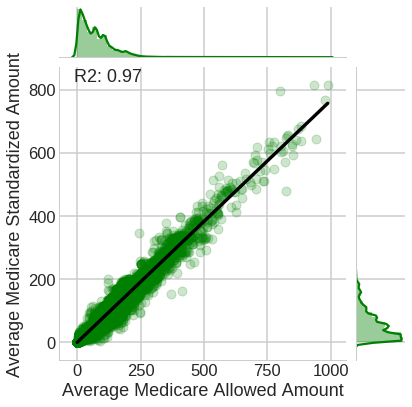

In [25]:
def lin_reg_plot(x,y,ax):
    sns.jointplot(x, y,
              kind='reg', color = 'green',
              joint_kws = {'scatter_kws':dict(alpha=0.2), 'line_kws': {'color':'black'}})
    X = sm.add_constant(x.values)
    res = sm.OLS(y.values, X).fit()
    plt.annotate("R2: {:.2f}".format(res.rsquared), xy=(0.05, 0.95), xycoords='axes fraction')
    
lin_reg_plot(data_usmed['Average Medicare Allowed Amount'], data_usmed['Average Medicare Standardized Amount'], ax)

## B. Robust regression using sklearn's RANSAC regressor.

This has a built in method of identifying outliers. We can compare the line of best fit produced by the RANSAC model to that produced by OLS.

In [26]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

Estimated coefficients (linear regression, RANSAC):
[[0.7651425]] [[0.76117442]]


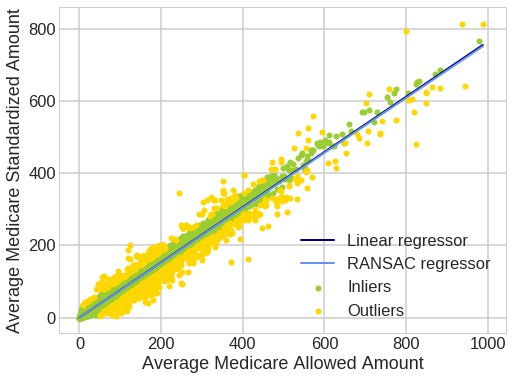

In [30]:
# Fit linear regression
lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y.reshape(-1, 1))

# Robustly fit linear model with RANSAC algorithm
ransac = RANSACRegressor()

X = data_usmed['Average Medicare Allowed Amount'].values
y = data_usmed['Average Medicare Standardized Amount'].values

ransac.fit(X.reshape(-1, 1), y.reshape(-1, 1))
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)

lw = 2
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Average Medicare Allowed Amount")
plt.ylabel("Average Medicare Standardized Amount")
plt.show()

Hmm, very little difference between the two. Perhaps this would be more useful on a smaller dataset with higher variance.

<a id='cblof'></a>
## 3. PCA and Cluster-Based Local Outlier Factor (CBLOF)

pyOD is a module specifically designed for outlier detection. One method is CBLOF, which is explained below: 

"CBLOF takes as an input the data set and the cluster model that was generated by a clustering algorithm. It classifies the clusters into small clusters and large clusters using the parameters alpha and beta. The anomaly score is then calculated based on the size of the cluster the point belongs to as well as the distance to the nearest large cluster. Use weighting for outlier factor based on the sizes of the clusters as proposed in the original publication. Since this might lead to unexpected behavior (outliers close to small clusters are not found), it is disabled by default.Outliers scores are solely computed based on their distance to the closest large cluster center. By default, kMeans is used for clustering algorithm instead of Squeezer algorithm mentioned in the original paper for multiple reasons."

A strategy to handle data with multiple financial details of claims could be to reduce the data to 2 dimensions, and use one of the spatial outlier detection methods included in the pyOD module, such as CBLOF.
Before fitting the model, the data must be normalized using sklearn's standard scaler.

In [117]:
from sklearn.preprocessing import StandardScaler

In [129]:
data_pca = pd.DataFrame(PCA(n_components=2).fit_transform(data_usmed[num_cols].values), columns = ['c1','c2'])
scaler = StandardScaler()
data_norm = scaler.fit_transform(data_pca)
data_norm = pd.DataFrame(data_norm, columns = ['c1','c2'])

In [35]:
from pyod.models.cblof import CBLOF

In [134]:
data_pca = pd.DataFrame(PCA(n_components=2).fit_transform(data_usmed[num_cols].values), columns = ['c1','c2'])
scaler = StandardScaler()
data_norm = scaler.fit_transform(data_pca)
data_norm = pd.DataFrame(data_norm, columns = ['c1','c2'])

# Assume the fraction of outliers to be 0.0005
outliers_fraction = 0.0005
xx, yy = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(data_norm)
scores_pred = clf.decision_function(data_norm) * -1
y_pred = clf.predict(data_norm)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
data_norm['outlier'] = y_pred

In [135]:
data_norm['outlier'] = y_pred

In [136]:
# sales - inlier feature 1,  profit - inlier feature 2
inliers_c1 = np.array(data_norm['c1'][data_norm['outlier'] == 0]).reshape(-1,1)
inliers_c2 = np.array(data_norm['c2'][data_norm['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_c1 = data_norm['c1'][data_norm['outlier'] == 1].values.reshape(-1,1)
outliers_c2 = data_norm['c2'][data_norm['outlier'] == 1].values.reshape(-1,1)

OUTLIERS: 46 INLIERS: 90582


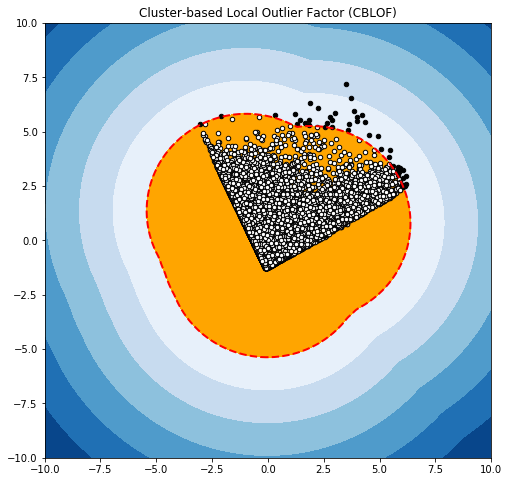

In [137]:
plt.figure(figsize=(8, 8))

print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = np.percentile(scores_pred, 100 * outliers_fraction)        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_c1, inliers_c2, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_c1, outliers_c2, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
#plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
#           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
#plt.xlim((0, 1))
#plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

This method has captured the most extreme outliers but also seems to have clipped the edge of the large cluster. 

<a id='knn'></a>
## K Nearest Neighbors Approach

KNN is a commonly used approach to classify clustered data. A KNN implementation is included in pyOD. By defining the fraction of expected outliers, they can be separated from non-suspicious cases.

In [138]:
from pyod.models.knn import KNN

OUTLIERS: 32 INLIERS: 90596


Text(0.5, 1.0, 'KNN derived outliers')

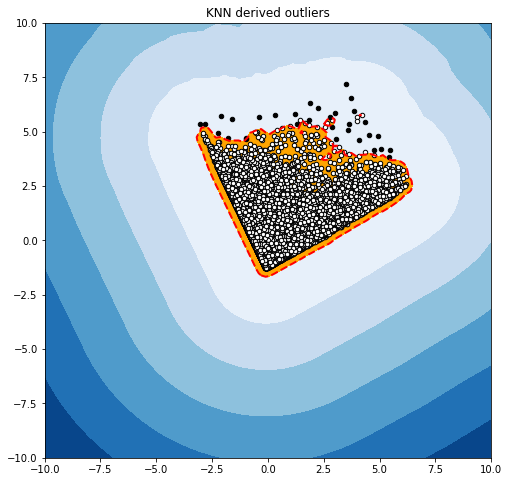

In [141]:
# Perform PCA to reduce data to 2D
data_pca = pd.DataFrame(PCA(n_components=2).fit_transform(data_usmed[num_cols].values), columns = ['c1','c2'])

# Scale the data to reduce large numbers
scaler = StandardScaler()
data_norm = scaler.fit_transform(data_pca)
data_norm = pd.DataFrame(data_norm, columns = ['c1','c2'])

# Choose the estimated fraction of outliers (trial and error)
outliers_fraction = 0.0005

# Create a meshgrid for the contour plots. Make sure the range is larger than the range of your PCA data!
xx, yy = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))

# Choose the outlier detection model and fit it to the data
clf = KNN(contamination=outliers_fraction)
clf.fit(data_norm)

# This function returns the raw anomaly score. The larger the magnitude, the more anomalous the data point is.
scores_pred = clf.decision_function(data_norm) * -1

# Returns binary array for inlier/outlier
y_pred = clf.predict(data_norm)

n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
data_norm['outlier'] = y_pred

# Create arrays for inliers for scatter plotting
inliers_c1 = np.array(data_norm['c1'][data_norm['outlier'] == 0]).reshape(-1,1)
inliers_c2 = np.array(data_norm['c2'][data_norm['outlier'] == 0]).reshape(-1,1)
    
# Create arrays for outliers for scatter plotting
outliers_c1 = data_norm['c1'][data_norm['outlier'] == 1].values.reshape(-1,1)
outliers_c2 = data_norm['c2'][data_norm['outlier'] == 1].values.reshape(-1,1)

plt.figure(figsize=(8, 8))

print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)

# Calculate the anomaly score threshold using percentile function
threshold = np.percentile(scores_pred, 100 * outliers_fraction)

# Map the decision function onto the meshgrid to create 2D matrix of anomaly scores
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# Plot contours for outliers from least extreme to most extreme (7 levels)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

# Plot decision boundary
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

# Shade the inlier zone orange
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

# Plot the data points
b = plt.scatter(inliers_c1, inliers_c2, c='white',s=20, edgecolor='k')    
c = plt.scatter(outliers_c1, outliers_c2, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.title('KNN derived outliers')

This does a better job of separating the dense cluster from the sparse outliers.

<a id='results'></a>
## 5. Results

What can we say about the claims we identified as outliers? Do any correspond to fraud? An experienced fraud detection team would be required to confirm that, but we have some interesting candidates. Particularly Dr. Alexander Talalight, who appears to have charged large amounts, well above the patients medicare allowancem for the act of 'injecting drug into eye.' We can probably rule out those claims corresponding to ER visits or ambulances as not suspcious.

In [148]:
df_outliers = data_usmed.reset_index()[data_norm['outlier']==1]

In [153]:
df_outliers

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
819,5280055,1538238936,PIEDMONT EMERGENCY RESCUE,NaN,NaN,NaN,NaN,O,121 W LADIGA ST,NaN,...,A0427,"Ambulance service, advanced life support, emer...",N,973.0,686.0,952.0,397.188972,550.000000,302.536331,327.762847
9118,7628447,1770586026,AL-SULEIMAN,OSAMA,NaN,MD,M,I,821 OAKLEY SEAVER DR,NaN,...,78452,Nuclear medicine study of vessels of heart usi...,N,230.0,230.0,230.0,476.990000,949.000000,363.746739,380.755696
14666,7529074,1760484919,CITY OF SALEM,NaN,NaN,NaN,NaN,O,105 S MARKET ST,NaN,...,A0427,"Ambulance service, advanced life support, emer...",N,960.0,679.0,955.0,410.000000,410.000000,318.012344,331.546365
15527,1950905,1194926741,SHROFF,GIRISH,S,MD,M,I,1515 HOLCOMBE BLVD,NaN,...,71260,CT scan chest with contrast,N,991.0,909.0,991.0,63.603602,385.000000,46.021009,44.902704
17172,6913154,1700094661,TALALIGHT,ALEXANDER,NaN,MD,M,I,2331 WHITESBURG DR S,NaN,...,67028,Injection of drug into eye,N,983.0,218.0,983.0,101.176806,803.519837,73.321567,80.875341
17557,4973825,1508833468,TAVEL,EDWARD,M,M.D.,M,I,2695 ELMS PLANTATION BLVD.,SUITE A,...,62323,Injection of substance into spinal canal of lo...,N,854.0,472.0,854.0,230.510000,890.000000,168.673548,186.753115
18399,1208172,1124066444,VANHOOSE,BRIAN,J,M.D.,M,I,1000 SAINT CHRISTOPHER DR,EMERGENCY DEPARTMENT,...,99285,"Emergency department visit, problem with signi...",N,915.0,791.0,915.0,170.090000,400.000000,129.216251,133.895290
22345,2061281,1205987831,LEWIS,MATTHEW,T,M.D.,M,I,1705 CHRISTY DR,STE. 101,...,J0178,"Injection, aflibercept, 1 mg",Y,246.0,29.0,123.0,978.462480,980.500000,767.115407,767.115407
26799,592888,1063405025,MULVANEY,MICHAEL,J,M.D.,M,I,264 WASHINGTON AVENUE EXT STE 201,NaN,...,14061,Tissue transfer repair of wound (10.1 to 30.0 ...,N,21.0,21.0,21.0,988.830000,988.830000,775.240000,813.990000
29790,5056024,1518194828,WILLIAMS,JAMIE,M,CRNA,F,I,1801 W 40TH AVE,SUITE 2B,...,00142,Anesthesia for lens surgery,N,970.0,761.0,970.0,112.140000,403.283505,86.064711,91.474351


In [154]:
df_outliers['HCPCS Code'].value_counts()

A0427    5
A0429    3
17311    3
99285    3
J9310    2
67028    2
99291    1
64483    1
14061    1
G6015    1
G0202    1
71260    1
78452    1
A0426    1
99203    1
15260    1
J0178    1
00142    1
66984    1
62323    1
Name: HCPCS Code, dtype: int64

In [155]:
df_outliers[df_outliers['HCPCS Code'] == 'A0427']

,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
819,5280055,1538238936,PIEDMONT EMERGENCY RESCUE,NaN,NaN,NaN,NaN,O,121 W LADIGA ST,NaN,...,A0427,"Ambulance service, advanced life support, emer...",N,973.0,686.0,952.0,397.188972,550.000000,302.536331,327.762847
14666,7529074,1760484919,CITY OF SALEM,NaN,NaN,NaN,NaN,O,105 S MARKET ST,NaN,...,A0427,"Ambulance service, advanced life support, emer...",N,960.0,679.0,955.0,410.000000,410.000000,318.012344,331.546365
34243,1132774,1114908506,"AREA SERVICES, INC.",NaN,NaN,NaN,NaN,O,705 N 6TH ST,NaN,...,A0427,"Ambulance service, advanced life support, emer...",N,949.0,678.0,949.0,414.562129,824.552160,319.824647,329.949505
76535,1734999,1174681712,CITY OF LEBANON,NaN,NaN,NaN,NaN,O,12 S. PARK STREET,NaN,...,A0427,"Ambulance service, advanced life support, emer...",N,583.0,455.0,582.0,450.794185,948.764082,350.544666,332.276278
89320,3916134,1396834230,CITY OF SANGER FIRE DEPARTMENT,NaN,NaN,NaN,NaN,O,1700 7TH ST,NaN,...,A0427,"Ambulance service, advanced life support, emer...",N,246.0,188.0,246.0,454.674390,975.000000,355.494350,334.354837


These entries correspond to organizations that offered large amounts of emergency rescue services, with cost nearly always exceeding the patients' allowed medicare amount.